In [17]:
import pandas as pd, numpy as np, yfinance as yf, matplotlib.pyplot as plt
from scipy import stats

def get_monthly_close(ticker: str, rename_to=None):
    data = yf.download(ticker, period="max", interval="1d", threads=False, auto_adjust=True)
    data.columns = data.columns.get_level_values(0)
    data = data.reset_index()[["Date", "Close"]]
    data.set_index("Date", inplace=True)
    monthly_close = data.resample("ME").last()["Close"]
    name = rename_to if rename_to else ticker
    return monthly_close.reset_index().rename(columns={"Close": name})

ibov = get_monthly_close("^BVSP", rename_to="IBOV")
btc_usd = get_monthly_close("BTC-USD")
usd_brl = get_monthly_close("BRL=X")

# Join and convert BTC to BRL
btc = pd.merge(btc_usd, usd_brl, on='Date', how="inner")
btc["BTC"] = btc["BTC-USD"] * btc["BRL=X"]
btc = btc[["Date", "BTC"]]

# Merge prices
df = pd.merge(ibov, btc, on="Date", how="inner").set_index("Date")
ret_m = df.pct_change().dropna()
ibov_full = ibov.set_index("Date")["IBOV"]
ret_ibov_full = ibov_full.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Kolmogorov–Smirnov – IBOV common vs full history:


,ks_stat,ks_p
horizon_m,,
12,0.200541,0.001143
24,0.226353,0.000327
36,0.192524,0.006570
48,0.190609,0.013281
60,0.210065,0.009601


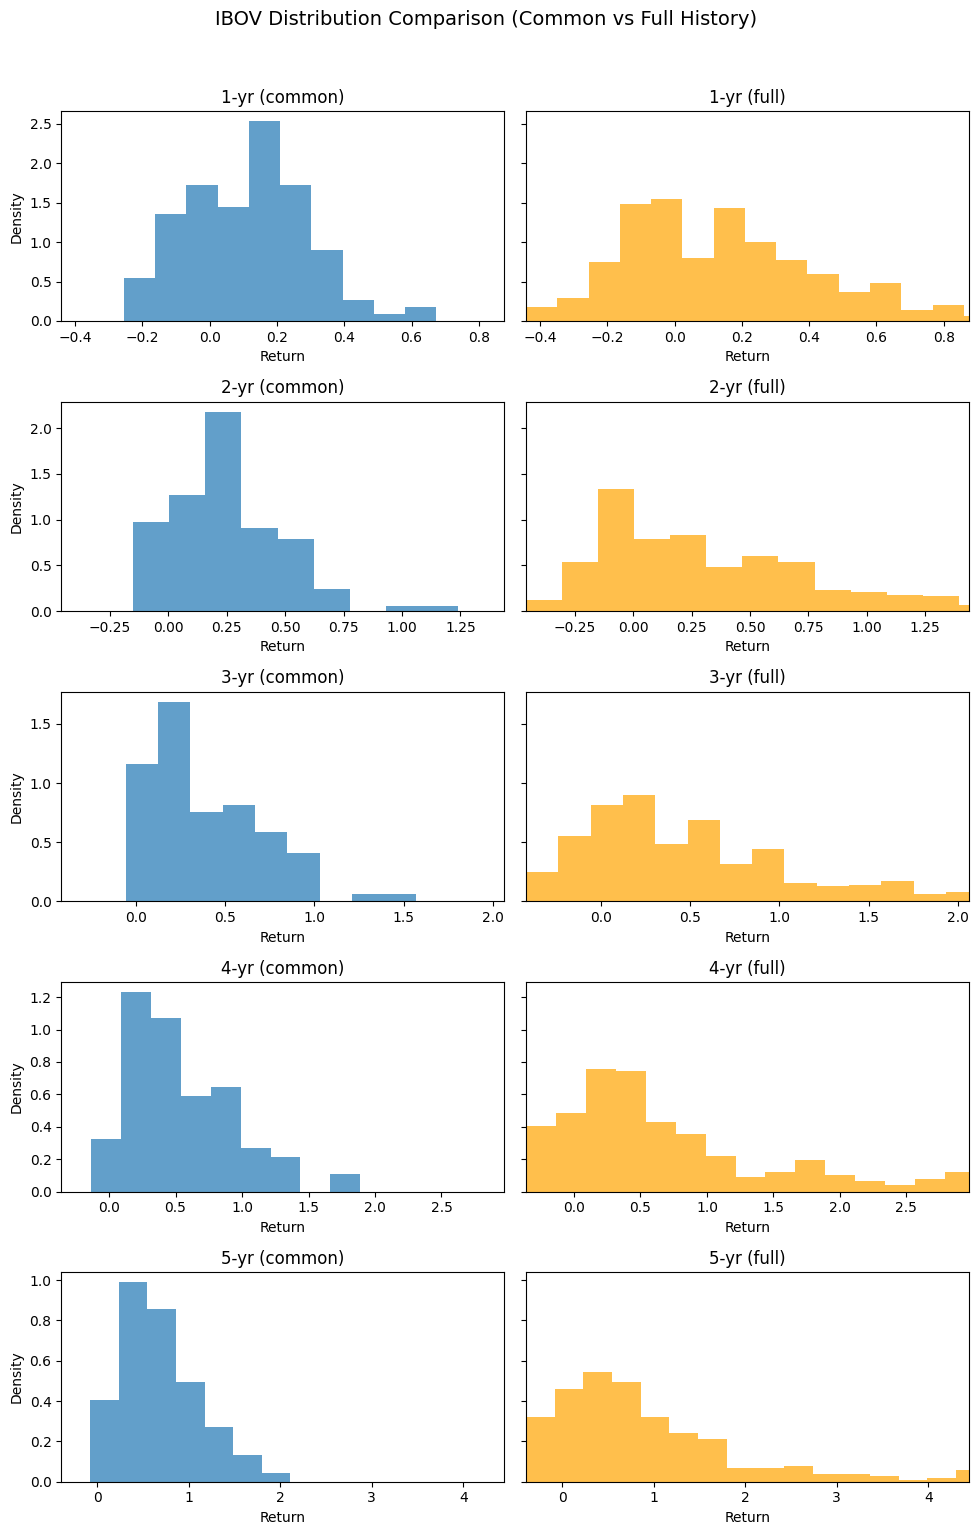

In [18]:
# ----- IBOV Distributions – Common vs Full History -----
def compounded(r, n): return (1 + r).rolling(n).apply(np.prod, raw=True) - 1
ks_records = []
horizons = [h for h in range(12, 61) if h % 12 == 0]
n_rows = len(horizons)

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 3 * n_rows), sharey='row')
fig.subplots_adjust(hspace=0.6)

for idx, h in enumerate(horizons):
    common = compounded(ret_m["IBOV"], h).dropna()
    full = compounded(ret_ibov_full, h).dropna()
    ks, p = stats.ks_2samp(common, full)
    ks_records.append({"horizon_m": h, "ks_stat": ks, "ks_p": p})

    combined = pd.concat([common, full])
    bins = np.histogram_bin_edges(combined, bins="auto")
    x1, x2 = combined.quantile([0, .95])

    ax_l, ax_r = axes[idx]
    ax_l.hist(common, bins=bins, density=True, alpha=.7)
    ax_l.set(title=f"{h//12}-yr (common)", xlabel="Return", ylabel="Density", xlim=(x1, x2))

    ax_r.hist(full, bins=bins, density=True, alpha=.7, color="orange")
    ax_r.set(title=f"{h//12}-yr (full)", xlabel="Return", xlim=(x1, x2))

ks_df = pd.DataFrame(ks_records).set_index("horizon_m")
print("Kolmogorov–Smirnov – IBOV common vs full history:"); display(ks_df); print('')

fig.suptitle("IBOV Distribution Comparison (Common vs Full History)", fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

In [19]:
# ----- Strategy Analysis -----
annual_cost = 0.06
min_windows  = 30
horizons     = range(12, 61)
records      = []

for h in horizons:
    comp = compounded(ret_m, h).dropna()
    if len(comp) < min_windows:
        continue

    gross_gain = comp["BTC"] - comp["IBOV"]       # long BTC, short IBOV
    cost       = annual_cost * h / 12
    tax        = gross_gain.clip(lower=0) * 0.15  # 15 % only if combined gain > 0
    net_strat  = gross_gain - tax - cost          # after-tax, after-cost

    q05,  q95  = gross_gain.quantile([.05, .95])
    nq05, nq95 = net_strat.quantile([.05, .95])

    records.append(dict(
        horizon_m = h, windows = len(comp),
        mean      = gross_gain.mean(),  p05 = q05,  p95 = q95,
        net_mean  = net_strat.mean(),  net_p05 = nq05, net_p95 = nq95,
        t_pvalue  = stats.ttest_1samp(net_strat, 0,
                                      alternative="greater").pvalue,
        wilcoxon_p= stats.wilcoxon(net_strat,
                                   alternative="greater").pvalue
    ))

stats_df = pd.DataFrame(records).set_index("horizon_m")
display(stats_df.style.format("{:.2%}",
        subset=["mean","p05","p95","net_mean","net_p05","net_p95"]))

,windows,mean,p05,p95,net_mean,net_p05,net_p95,t_pvalue,wilcoxon_p
horizon_m,,,,,,,,,
12,119,156.64%,-69.46%,687.11%,125.86%,-75.46%,578.04%,0.000000,0.000000
13,118,179.44%,-62.70%,776.50%,144.70%,-69.20%,653.52%,0.000000,0.000000
14,117,201.18%,-55.38%,757.58%,162.62%,-62.38%,636.94%,0.000000,0.000000
15,116,225.08%,-58.84%,910.74%,182.36%,-66.34%,766.63%,0.000000,0.000000
16,115,247.30%,-55.24%,902.84%,200.75%,-63.24%,759.42%,0.000000,0.000000
17,114,267.30%,-53.52%,920.39%,217.28%,-62.02%,773.83%,0.000000,0.000000
18,113,288.29%,-49.36%,1097.85%,234.75%,-58.36%,924.17%,0.000000,0.000000
19,112,313.52%,-54.54%,1189.97%,255.80%,-64.04%,1001.97%,0.000000,0.000000
20,111,341.12%,-54.00%,1161.90%,278.81%,-64.00%,977.61%,0.000000,0.000000


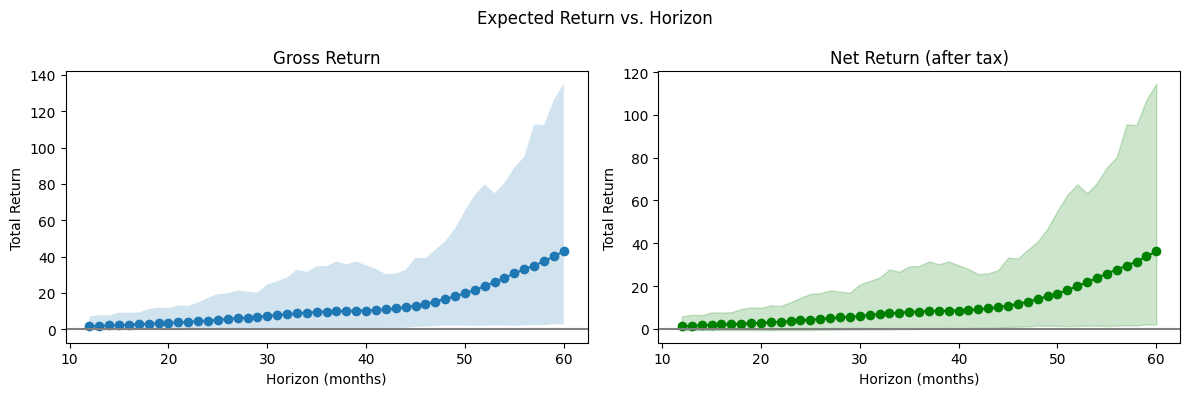

In [20]:
# ----- Plot Total Return (Gross vs Net) -----
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(stats_df.index, stats_df["mean"], marker="o")
ax[0].fill_between(stats_df.index, stats_df["p05"], stats_df["p95"], alpha=.2)
ax[0].axhline(0, color="grey")
ax[0].set(title="Gross Return", xlabel="Horizon (months)", ylabel="Total Return")

ax[1].plot(stats_df.index, stats_df["net_mean"], marker="o", color="green")
ax[1].fill_between(stats_df.index, stats_df["net_p05"], stats_df["net_p95"], alpha=.2, color="green")
ax[1].axhline(0, color="grey")
ax[1].set(title="Net Return (after tax)", xlabel="Horizon (months)", ylabel="Total Return")

plt.suptitle("Expected Return vs. Horizon"); plt.tight_layout(); plt.show()

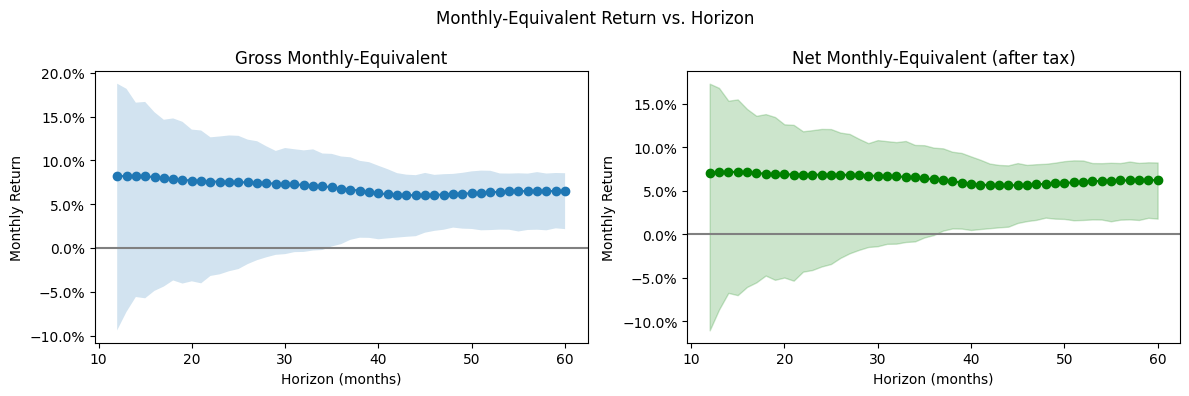

In [21]:
# ----- Monthly-Equivalent Returns (Gross vs Net) -----
from matplotlib.ticker import PercentFormatter

eq     = lambda s: (1+s)**(1/stats_df.index) - 1
eq_mean,  eq_p05,  eq_p95  = map(eq, (stats_df["mean"], stats_df["p05"],  stats_df["p95"]))
eq_nmean, eq_np05, eq_np95 = map(eq, (stats_df["net_mean"], stats_df["net_p05"], stats_df["net_p95"]))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(stats_df.index, eq_mean, marker="o")
ax[0].fill_between(stats_df.index, eq_p05, eq_p95, alpha=.2)
ax[0].axhline(0, color="grey")
ax[0].set(title="Gross Monthly-Equivalent", xlabel="Horizon (months)", ylabel="Monthly Return")
ax[0].yaxis.set_major_formatter(PercentFormatter(1))

ax[1].plot(stats_df.index, eq_nmean, marker="o", color="green")
ax[1].fill_between(stats_df.index, eq_np05, eq_np95, alpha=.2, color="green")
ax[1].axhline(0, color="grey")
ax[1].set(title="Net Monthly-Equivalent (after tax)", xlabel="Horizon (months)", ylabel="Monthly Return")
ax[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.suptitle("Monthly-Equivalent Return vs. Horizon"); plt.tight_layout(); plt.show()

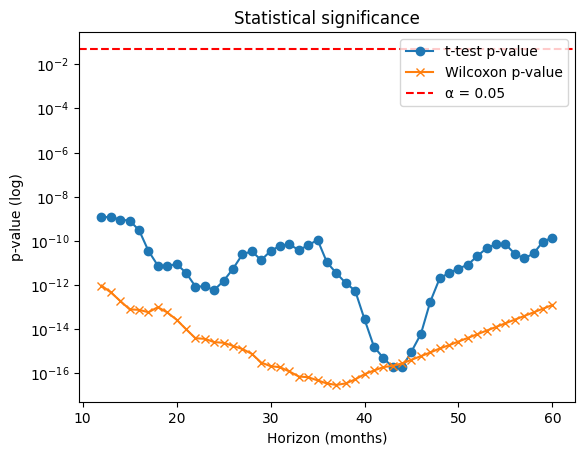

In [22]:
# ----- p-value plot -----
plt.figure()
plt.plot(stats_df.index, stats_df["t_pvalue"], marker="o", label="t-test p-value")
plt.plot(stats_df.index, stats_df["wilcoxon_p"], marker="x", label="Wilcoxon p-value")
plt.axhline(0.05, color="red", linestyle="--", label="α = 0.05")
plt.yscale("log"); plt.xlabel("Horizon (months)"); plt.ylabel("p-value (log)")
plt.title("Statistical significance"); plt.legend(); plt.show()

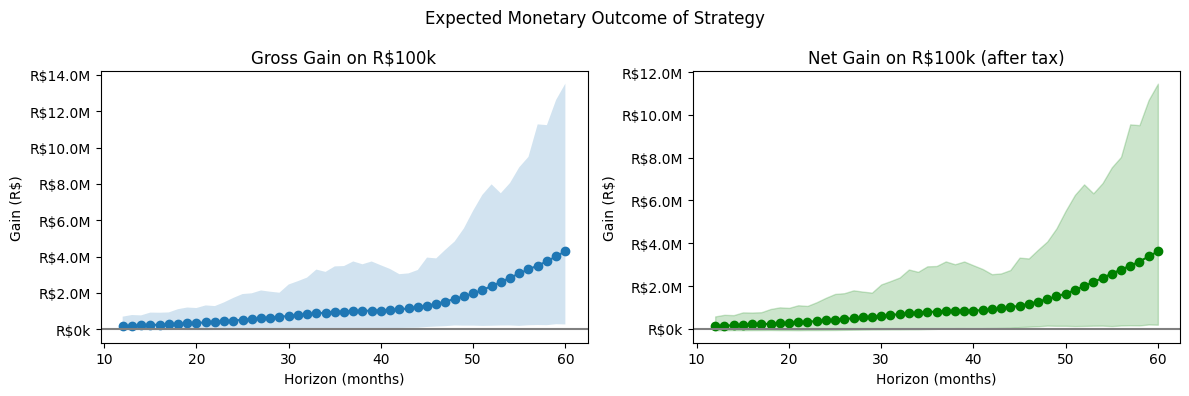

In [23]:
# ----- Monetary Interpretation (Gross vs Net) -----
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    if x >= 1_000_000:
        return f'R${x/1_000_000:.1f}M'
    return f'R${x/1_000:.0f}k'

capital = 100_000
rounded_k = int(round(capital / 1000)) * 1000
label_k = f"R${int(round(rounded_k / 1000))}k"

gross_val = stats_df[["mean", "p05", "p95"]].mul(capital)
net_val   = stats_df[["net_mean", "net_p05", "net_p95"]].mul(capital)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(gross_val.index, gross_val["mean"], marker="o")
ax[0].fill_between(gross_val.index, gross_val["p05"], gross_val["p95"], alpha=.2)
ax[0].axhline(0, color="grey")
ax[0].set(title=f"Gross Gain on {label_k}", xlabel="Horizon (months)", ylabel="Gain (R$)")
ax[0].yaxis.set_major_formatter(FuncFormatter(thousands))

ax[1].plot(net_val.index, net_val["net_mean"], marker="o", color="green")
ax[1].fill_between(net_val.index, net_val["net_p05"], net_val["net_p95"], alpha=.2, color="green")
ax[1].axhline(0, color="grey")
ax[1].set(title=f"Net Gain on {label_k} (after tax)", xlabel="Horizon (months)", ylabel="Gain (R$)")
ax[1].yaxis.set_major_formatter(FuncFormatter(thousands))

plt.suptitle("Expected Monetary Outcome of Strategy")
plt.tight_layout()
plt.show()

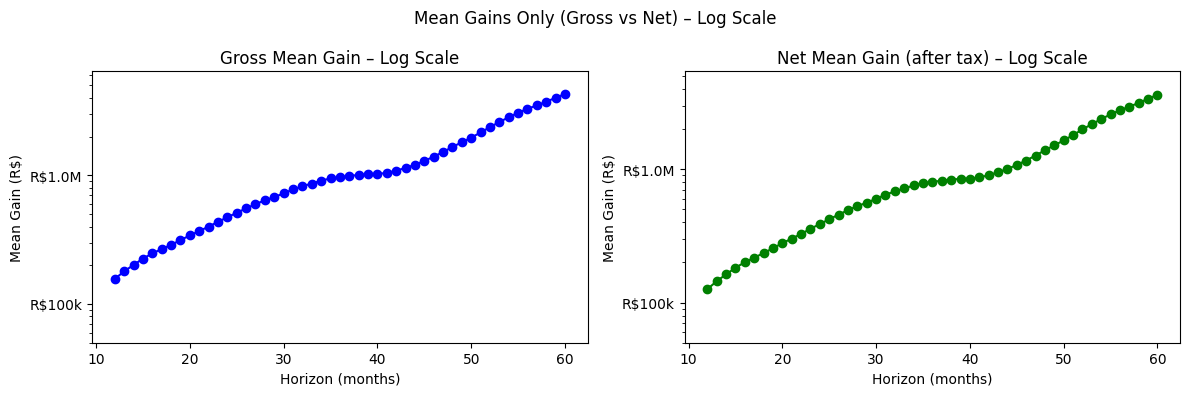

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Gross
ax[0].plot(gross_val.index, gross_val["mean"], marker="o", color="blue")
ax[0].set_yscale("log")
ax[0].yaxis.set_major_formatter(FuncFormatter(thousands))
ax[0].set_ylim(max(capital * 0.5, 1), gross_val["mean"].max() * 1.5)
ax[0].set_title("Gross Mean Gain – Log Scale")
ax[0].set_xlabel("Horizon (months)")
ax[0].set_ylabel("Mean Gain (R$)")

# Net
ax[1].plot(net_val.index, net_val["net_mean"], marker="o", color="green")
ax[1].set_yscale("log")
ax[1].yaxis.set_major_formatter(FuncFormatter(thousands))
ax[1].set_ylim(max(capital * 0.5, 1), net_val["net_mean"].max() * 1.5)
ax[1].set_title("Net Mean Gain (after tax) – Log Scale")
ax[1].set_xlabel("Horizon (months)")
ax[1].set_ylabel("Mean Gain (R$)")

plt.suptitle("Mean Gains Only (Gross vs Net) – Log Scale")
plt.tight_layout()
plt.show()